In [22]:
%load_ext autoreload
%autoreload 2

# ignore warnings for readability
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch
import torch.nn as nn
from os.path import join
import matplotlib as mpl
mpl.style.use('../../style.mcstyle')   # noqa

import ili
from ili.dataloaders import NumpyLoader
from ili.inference import InferenceRunner
from ili.validation.metrics import PosteriorCoverage, PlotSinglePosterior

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Device: cpu


In [20]:
wdir = '/anvil/scratch/x-mho1/cmass-ili/quijote/nbody/models/halo/zPk0/kmin-0.0_kmax-0.4'

x_train = np.load(join(wdir, 'x_train.npy'))
theta_train = np.load(join(wdir, 'theta_train.npy'))

wdir = '/anvil/scratch/x-mho1/cmass-ili/abacus1gpch/custom/models/halo/zPk0/kmin-0.0_kmax-0.4'
x_test = np.load(join(wdir, 'x_test.npy'))
theta_test = np.load(join(wdir, 'theta_test.npy'))

print('x_train shape:', x_train.shape)
print('theta_train shape:', theta_train.shape)

x_train shape: (1600, 63)
theta_train shape: (1600, 5)


## Generate p(x|theta)

In [16]:
x = theta_train
theta = x_train

# make a dataloader
loader = NumpyLoader(x=x, theta=theta)

# define a prior
prior = ili.utils.Uniform(
    low=[-1000.]*theta.shape[-1], high=[1000.]*theta.shape[-1], device=device)

# instantiate your neural networks to be used as an ensemble
nets = [
    ili.utils.load_nde_sbi(engine='NPE', model='maf',
                           hidden_features=8, num_transforms=2),
    # ili.utils.load_nde_sbi(engine='NPE', model='made',
    #                        hidden_features=16, num_transforms=4),
]

# define training arguments
train_args = {
    'training_batch_size': 32,
    'learning_rate': 1e-3
}

# initialize the trainer
runner = InferenceRunner.load(
    backend='sbi',
    engine='NPE',
    prior=prior,
    nets=nets,
    device=device,
    train_args=train_args,
    proposal=None,
    out_dir=None
)

In [17]:
# train the model. this outputs a posterior model and training logs
posterior_ensemble, summaries = runner(loader=loader)

INFO:root:MODEL INFERENCE CLASS: NPE
INFO:root:Training model 1 / 1.


 Neural network successfully converged after 417 epochs.

INFO:root:It took 251.41261625289917 seconds to train models.


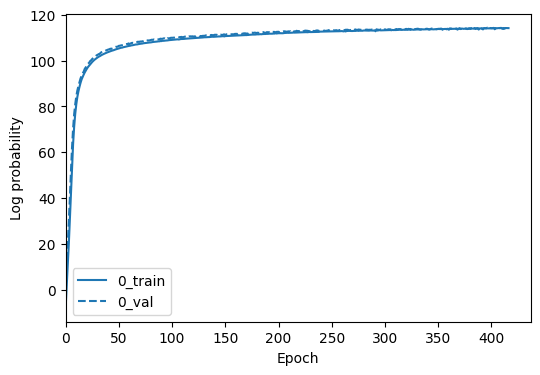

In [18]:
# plot train/validation loss
f, ax = plt.subplots(1, 1, figsize=(6, 4))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()

In [19]:
# choose a random input
seed_ind = 24
np.random.seed(seed_ind)
ind = np.random.randint(len(theta))

# generate samples from the posterior using MCMC
samples = posterior_ensemble.sample(
    (1000,), x[ind],
).detach().cpu().numpy()

# calculate the potential (prop. to log_prob) for each sample
log_prob = posterior_ensemble.log_prob(
    samples,
    x[ind]
).detach().cpu().numpy()

Drawing 1000 posterior samples: 100%|██████████| 1000/1000 [00:00<00:00, 1070.19it/s]


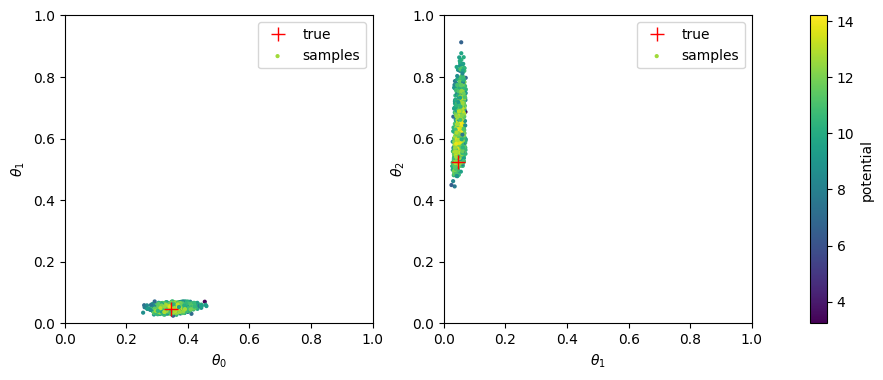

In [14]:
# plot the posterior samples and the true value
f, axs = plt.subplots(1, 3, figsize=(10, 4), gridspec_kw={
                      'width_ratios': [1, 1, 0.05]})
for i in range(2):
    axs[i].plot(theta[ind, i], theta[ind, i+1],
                'r+', markersize=10, label='true')
    im = axs[i].scatter(samples[:, i], samples[:, i+1],
                        c=log_prob, s=4, label='samples')
    axs[i].set_aspect('equal')
    axs[i].set_xlim(0, 1)
    axs[i].set_ylim(0, 1)
    axs[i].set_xlabel(f'$\\theta_{i}$')
    axs[i].set_ylabel(f'$\\theta_{i+1}$')
    axs[i].legend()
plt.colorbar(im, label='potential', use_gridspec=True, cax=axs[2])

Text(0.5, 0, '$k$ [h/Mpc]')

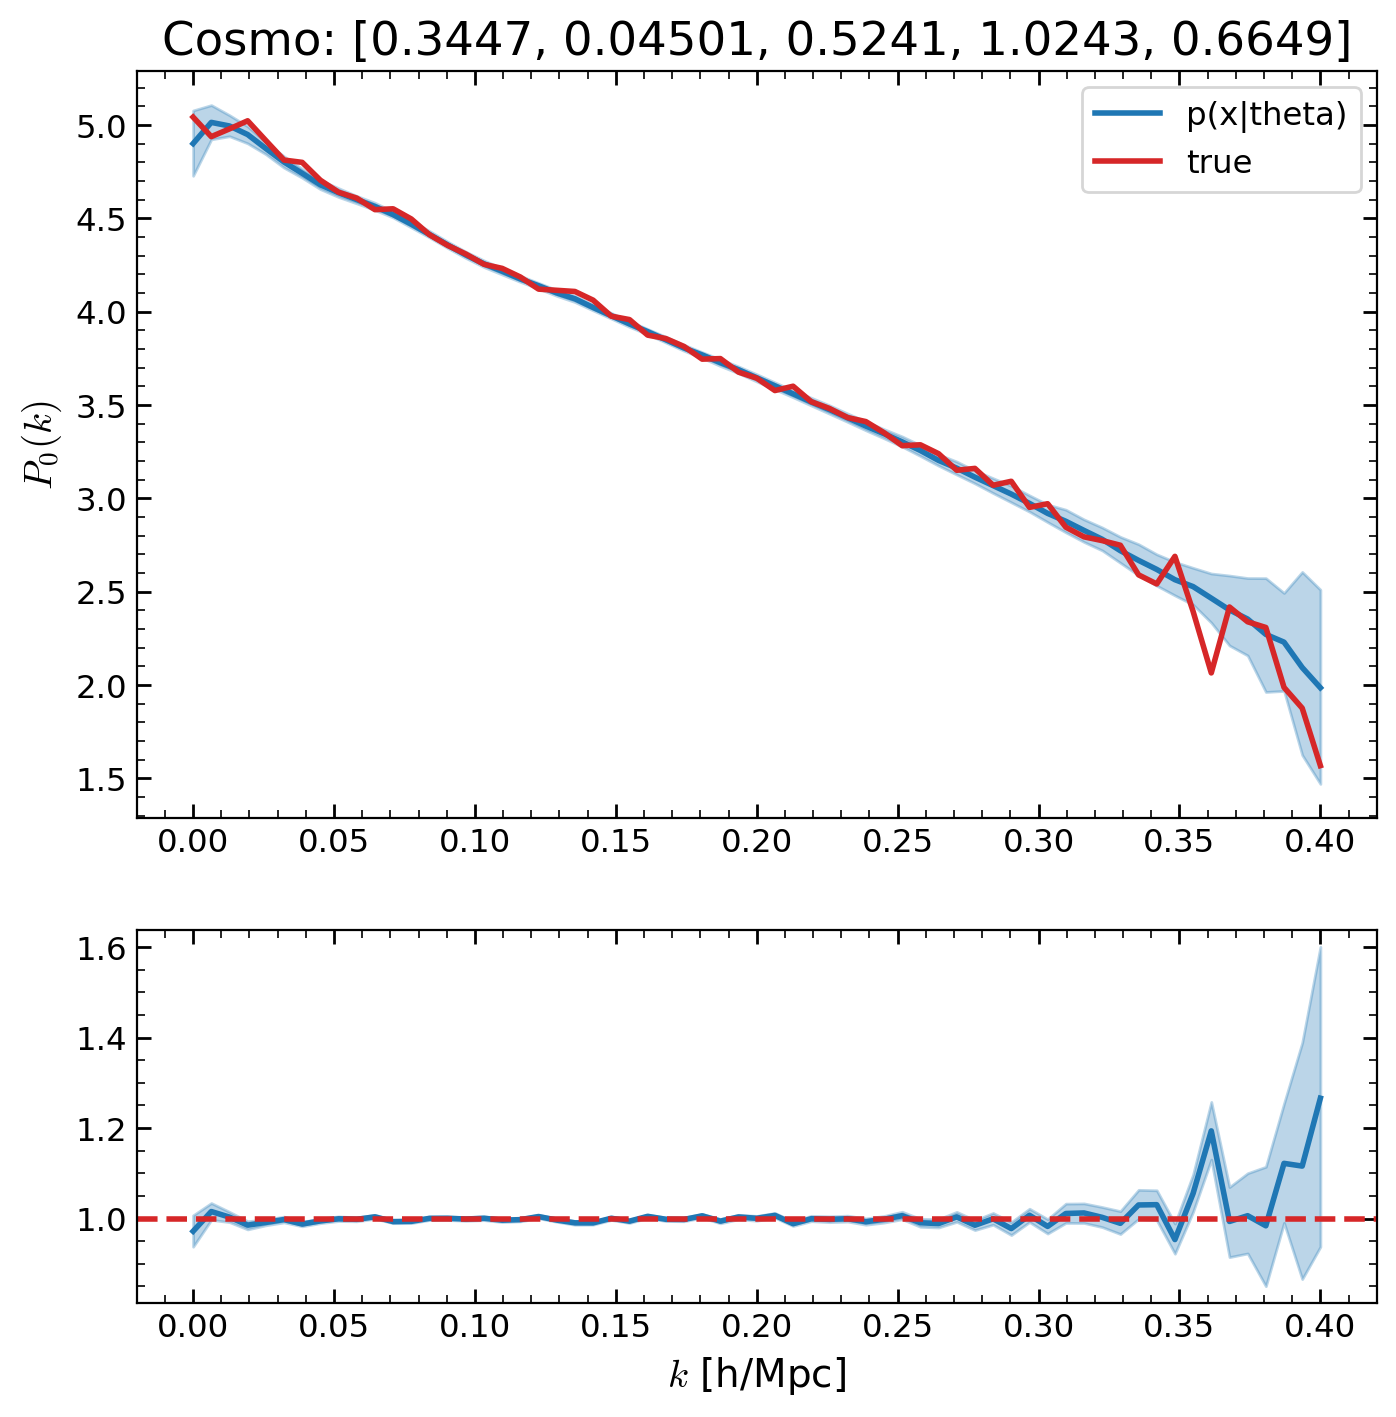

In [ ]:
f, axs = plt.subplots(2, 1, figsize=(8, 8), gridspec_kw={
                      'height_ratios': [1, 0.5]})

ax = axs[0]
y_ = theta[ind]
x_ = np.linspace(0, 0.4, samples.shape[-1])
percs = np.percentile(samples, [50, 16, 84], axis=0)
ax.plot(x_, percs[0], c='C0', label='p(x|theta)')
ax.fill_between(
    x_, percs[1], percs[2], color='C0', alpha=0.3)
ax.plot(x_, y_, c='C3', label='true')
# ax.set_xlabel('$k$ [h/Mpc]')
ax.set_ylabel('$P_0(k)$')
ax.legend()
ax.set_title(f'Cosmo: {x[ind].tolist()}')

ax = axs[1]
ax.plot(x_, percs[0]/y_, c='C0', label='p(x|theta)')
ax.fill_between(
    x_, percs[1]/y_, percs[2]/y_, color='C0', alpha=0.3)
ax.axhline(1, ls='--', c='C3')
ax.set_xlabel('$k$ [h/Mpc]')

In [46]:
# choose a random input
seed_ind = 24
np.random.seed(seed_ind)
ind = 80

# generate samples from the posterior using MCMC
samples = posterior_ensemble.sample(
    (1000,), theta_test[ind],
).detach().cpu().numpy()

Drawing 1000 posterior samples: 100%|██████████| 1000/1000 [00:01<00:00, 540.70it/s]


(0.8, 1.2)

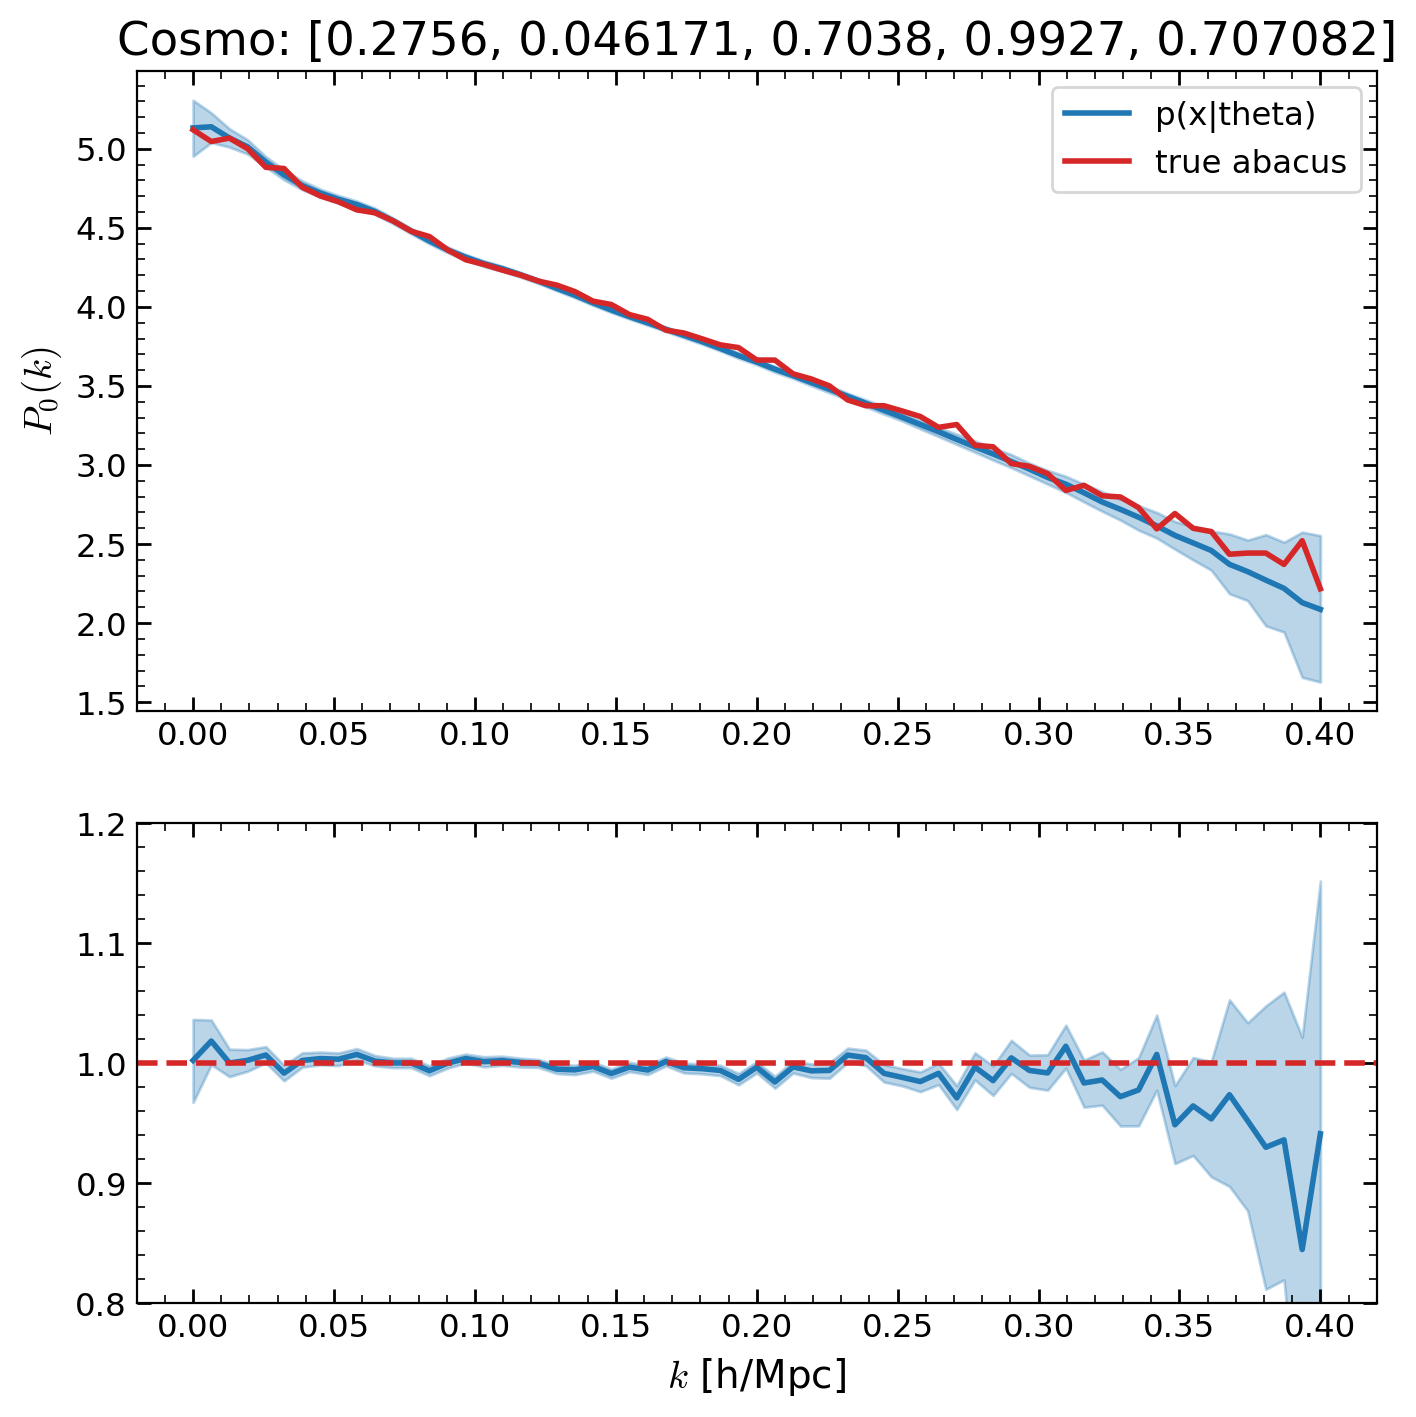

In [ ]:
f, axs = plt.subplots(2, 1, figsize=(8, 8), gridspec_kw={
                      'height_ratios': [1, 0.75]})

ax = axs[0]
y_ = x_test[ind]
x_ = np.linspace(0, 0.4, samples.shape[-1])
percs = np.percentile(samples, [50, 16, 84], axis=0)
ax.plot(x_, percs[0], c='C0', label='p(x|theta)')
ax.fill_between(
    x_, percs[1], percs[2], color='C0', alpha=0.3)
ax.plot(x_, y_, c='C3', label='true abacus')
# ax.set_xlabel('$k$ [h/Mpc]')
ax.set_ylabel('$P_0(k)$')
ax.legend()
ax.set_title(f'Cosmo: {theta_test[ind].tolist()}')

ax = axs[1]
ax.plot(x_, percs[0]/y_, c='C0', label='p(x|theta)')
ax.fill_between(
    x_, percs[1]/y_, percs[2]/y_, color='C0', alpha=0.3)
ax.axhline(1, ls='--', c='C3')
ax.set_xlabel('$k$ [h/Mpc]')
ax.set_ylim(0.8, 1.2)

## Sample P(theta|x) with NLE